In [18]:
import requests
import numpy as np
import json
import pandas as pd
from datetime import datetime, timedelta
import sklearn
end_date = datetime(2024, 6, 1)
start_date = end_date - timedelta(days=5000)


In [61]:
API_KEY = "wUvM2M29ZVxHDvK8IRp2P7iyrT8uhQG4"

ticker = "AAPL"

url_hist_stock_price = f"https://financialmodelingprep.com/stable/historical-price-eod/light?symbol={ticker}&from={start_date.date()}&to={end_date.date()}&apikey={API_KEY}"

# Historical Data Request
response_hist_stock_price = requests.get(url_hist_stock_price)

json_response_hist_stock_price = response_hist_stock_price.json()

df_stock_hist = pd.DataFrame(json_response_hist_stock_price)

df_stock_hist['date'] = pd.to_datetime(df_stock_hist['date'])
df_stock_hist['price'] = df_stock_hist['price'].astype(float)
df_stock_hist['volume'] = df_stock_hist['volume'].astype(float)


df_stock_hist.set_index('date', inplace=True)
df_stock_hist.drop(columns=['symbol'])

closing_price = df_stock_hist[['price']]
i_volume = df_stock_hist[['volume']]
volume =i_volume.apply(np.log10)

In [120]:
# Daily Return
daily_return = closing_price.pct_change()
# 5-Day Return
ret_5d = closing_price.pct_change(5)
# 10-Day Return
ret_10d = closing_price.pct_change(10)

# 5-Day Volatility (Std Dev of Returns)
vol_5d = closing_price.pct_change().rolling(window=5).std()

# 10-Day Volatility
vol_10d = (closing_price.pct_change().rolling(window=10).std())

# Momentum (10d)
momentum_10d = closing_price - closing_price.shift(10)

# SMA_10/SMA_50 Ratio
sma_10 = closing_price.rolling(window=10).mean()
sma_50 = closing_price.rolling(window=50).mean()
sma_ratio = sma_10/sma_50

# Z-score (20d)
rolling_mean = closing_price.rolling(window=20).mean()
rolling_std = closing_price.rolling(window=20).std()
z_score_20d = (closing_price - rolling_mean)/rolling_std

# RSI (14d)
delta = closing_price.diff()
gain = delta.where(delta > 0, 0.0)
loss = -delta.where(delta < 0, 0.0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain/avg_loss
rsi_14 = 100 - (100 / (1 + rs))

pd.set_option('display.max_rows', None)


future_return = closing_price.pct_change(-30) 

# Step 2: Compute quantiles
q = future_return.quantile([0.1, 0.3, 0.7, 0.9]) 
def classify_return(r,q):
    if r >= q['price'].iloc[3]:
        return 4   # Strong Up
    elif r >= q['price'].iloc[2]:
        return 3   # Up
    elif r >= q['price'].iloc[1]:
        return 2   # Neutral
    elif r >= q['price'].iloc[0]:
        return 1  # Down
    else:
        return 0 # Strong Down

# Apply classification



future_return['price'] = future_return['price'].apply(lambda r : classify_return(r,q))
#y['price'] = y['price'].apply(classify_return)


dataframes = [
    (daily_return, 'ret_1d'),
    (ret_5d, 'ret_5d'),
    (ret_10d, 'ret_10d'),
    (vol_5d, 'vol_5d'),
    (vol_10d, 'vol_10d'),
    (momentum_10d, 'momentum_10d'),
    (sma_ratio, 'sma_ratio_10_50'),
    (z_score_20d, 'zscore_20d'),
    (rsi_14, 'rsi_14'),
    (volume,'volume'),
    (future_return,'y'),
]

df_features_short_term = pd.concat(
    [df.rename(columns={df.columns[0]: name}) for df, name in dataframes],
    axis=1
).dropna()
X_not_scaled = df_features_short_term.drop(columns=["y"])
y_not_scaled = df_features_short_term[["y"]]
print(y_not_scaled)

            y
date         
2024-03-21  0
2024-03-20  1
2024-03-19  1
2024-03-18  1
2024-03-15  1
2024-03-14  1
2024-03-13  1
2024-03-12  0
2024-03-11  0
2024-03-08  0
2024-03-07  0
2024-03-06  0
2024-03-05  0
2024-03-04  1
2024-03-01  1
2024-02-29  2
2024-02-28  2
2024-02-27  2
2024-02-26  1
2024-02-23  2
2024-02-22  2
2024-02-21  2
2024-02-20  2
2024-02-16  2
2024-02-15  2
2024-02-14  2
2024-02-13  1
2024-02-12  1
2024-02-09  1
2024-02-08  1
2024-02-07  1
2024-02-06  1
2024-02-05  1
2024-02-02  1
2024-02-01  1
2024-01-31  1
2024-01-30  1
2024-01-29  1
2024-01-26  2
2024-01-25  2
2024-01-24  2
2024-01-23  2
2024-01-22  2
2024-01-19  2
2024-01-18  2
2024-01-17  1
2024-01-16  1
2024-01-12  2
2024-01-11  1
2024-01-10  2
2024-01-09  1
2024-01-08  1
2024-01-05  1
2024-01-04  1
2024-01-03  1
2024-01-02  1
2023-12-29  2
2023-12-28  2
2023-12-27  2
2023-12-26  2
2023-12-22  2
2023-12-21  2
2023-12-20  2
2023-12-19  3
2023-12-18  3
2023-12-15  3
2023-12-14  3
2023-12-13  4
2023-12-12  3
2023-1

In [121]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_not_scaled)
X_scaled = scaler.transform(X_not_scaled)
df_scaled = pd.DataFrame(X_scaled, index=X_not_scaled.index, columns=X_not_scaled.columns)
df_scaled['y'] = y_not_scaled

array([[<Axes: xlabel='ret_1d', ylabel='ret_1d'>,
        <Axes: xlabel='ret_5d', ylabel='ret_1d'>,
        <Axes: xlabel='ret_10d', ylabel='ret_1d'>,
        <Axes: xlabel='vol_5d', ylabel='ret_1d'>,
        <Axes: xlabel='vol_10d', ylabel='ret_1d'>,
        <Axes: xlabel='momentum_10d', ylabel='ret_1d'>,
        <Axes: xlabel='sma_ratio_10_50', ylabel='ret_1d'>,
        <Axes: xlabel='zscore_20d', ylabel='ret_1d'>,
        <Axes: xlabel='rsi_14', ylabel='ret_1d'>,
        <Axes: xlabel='volume', ylabel='ret_1d'>,
        <Axes: xlabel='y', ylabel='ret_1d'>],
       [<Axes: xlabel='ret_1d', ylabel='ret_5d'>,
        <Axes: xlabel='ret_5d', ylabel='ret_5d'>,
        <Axes: xlabel='ret_10d', ylabel='ret_5d'>,
        <Axes: xlabel='vol_5d', ylabel='ret_5d'>,
        <Axes: xlabel='vol_10d', ylabel='ret_5d'>,
        <Axes: xlabel='momentum_10d', ylabel='ret_5d'>,
        <Axes: xlabel='sma_ratio_10_50', ylabel='ret_5d'>,
        <Axes: xlabel='zscore_20d', ylabel='ret_5d'>,
        <Axe

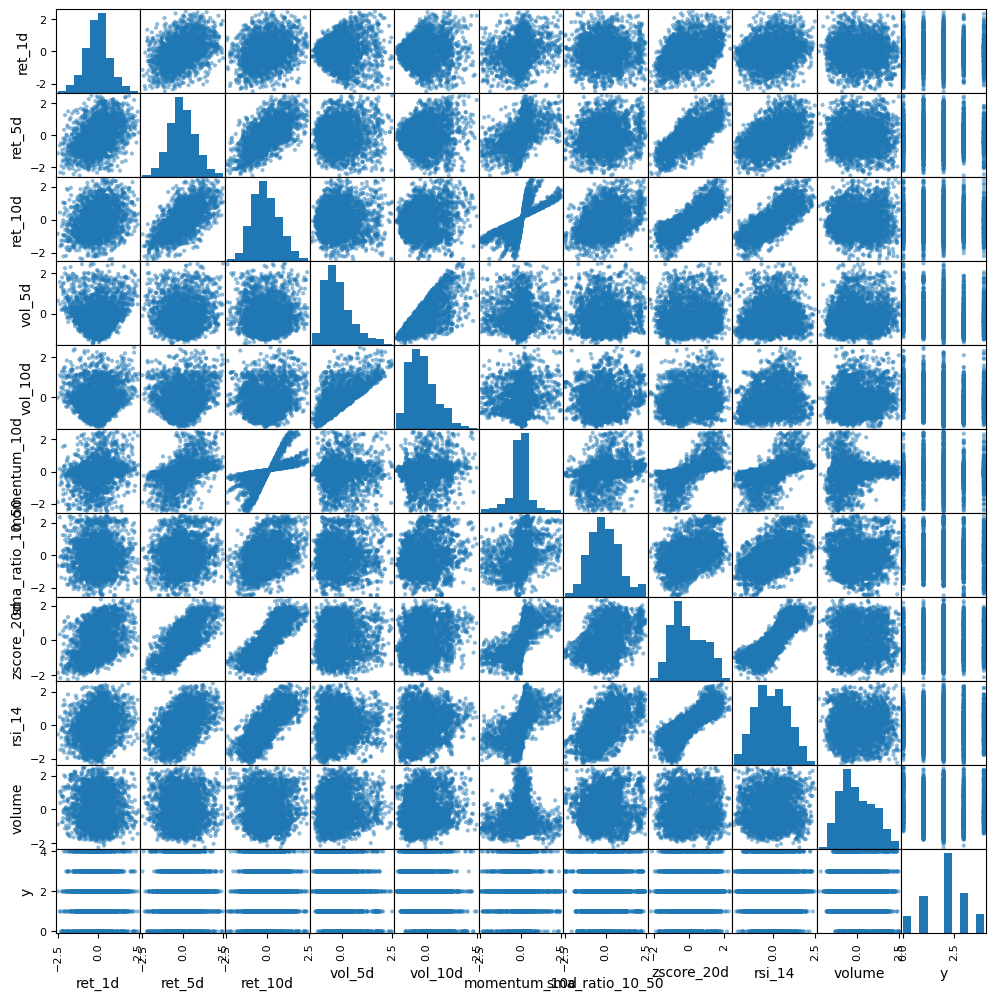

In [122]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

# Calculate Z-scores for the dataset
z_scores = np.abs(zscore(df_scaled))

# Set a threshold for identifying outliers (commonly 3)
threshold = 2.5 # confidence interval of data around 97.6 %.

# Identify rows where any column has a Z-score greater than threshold
outliers = (z_scores > threshold).any(axis=1)

# Remove outliers
df_no_outliers = df_scaled[~outliers]

# DATA ANALYSIS

from pandas.plotting import scatter_matrix

scatter_matrix(df_no_outliers, figsize=(12, 12), diagonal='hist')  # or 'kde'

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X = df_no_outliers.drop(columns=['y'])
# Target Columns
y = df_no_outliers['y']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

model = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=1.0,
    reg_lambda = 1
)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 0.44333333333333336
Confusion Matrix:
 [[ 13   3  27   0   1]
 [  3  13  94   2   3]
 [ 10  11 201  21   1]
 [  3   2  94  30   1]
 [ 10   3  37   8   9]]


In [124]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 1, 10]  # L2 regularization
}

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss'
)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    verbose=2,
    n_jobs=-1,  
)

grid.fit(X_train, y_train)
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 10 folds for each of 972 candidates, totalling 9720 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=2, n_estimators=100, reg_lambda=0, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=2, n_estimators=100, reg_lambda=0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=2, n_estimators=100, reg_lambda=0, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=2, n_estimators=100, reg_lambda=0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=2, n_estimators=100, reg_lambda=0, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=2, n_estimators=100, reg_lambda=0, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=2, n_estimators=100, reg_lambda=0, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree